# Setup

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL, einops
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

## Goal: Create a cellular automata that can match the texture of our style image:

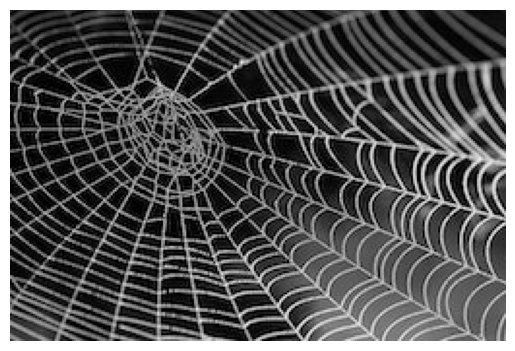

In [ ]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.
url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
style_im = download_image(url).to(def_device)
show_image(style_im);

## Style Loss (see 17A):

In [ ]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def calc_features(imgs, target_layers=[18, 25]): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

# Batched version of the previous notebook's gram matrix function
def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return L(torch.einsum('bchw, bdhw -> cd', x, x) / (x.shape[-2]*x.shape[-1])
            for x in calc_features(img, target_layers))

class StyleLossToTarget():
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im[None], target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [ ]:
style_loss = StyleLossToTarget(style_im)
style_loss(torch.rand(1, 3, 256, 256).to(def_device))

tensor(1205.7981, device='cuda:0', grad_fn=<AddBackward0>)

## Defining the NCA model

In [ ]:
num_channels = 4
hidden_n = 8

In [ ]:
def make_grids(n, sz=128): return torch.zeros(n, num_channels, sz, sz).to(def_device)

In [ ]:
# Hard-coded filters
filters = torch.stack([
    tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
    tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
]).to(def_device)

In [ ]:
def perchannel_conv(x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = F.pad(y, [1, 1, 1, 1], 'circular') # << Note pad mode
    y = F.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)

In [ ]:
x = make_grids(1)
model_inputs = perchannel_conv(x, filters)
model_inputs.shape

torch.Size([1, 16, 128, 128])

In [ ]:
# Brain: linear layer style
brain = nn.Sequential(
    nn.Linear(num_channels*4, hidden_n),
    nn.ReLU(),
    nn.Linear(hidden_n, num_channels)
).to(def_device)
model_inputs_flat = einops.rearrange(model_inputs, 'b c h w -> (b h w) c') # (1*128*128, 16)
brain_preds = brain(model_inputs_flat).reshape(x.shape)
brain_preds.shape

torch.Size([1, 4, 128, 128])

In [ ]:
# Brain: conv style
brain = nn.Sequential(
    nn.Conv2d(num_channels*4, hidden_n, 1),
    nn.ReLU(),
    nn.Conv2d(hidden_n, num_channels, 1, bias=False)
).to(def_device)
brain_preds = brain(model_inputs).reshape(x.shape)
brain_preds.shape

torch.Size([1, 4, 128, 128])

In [ ]:
class SimpleCA(nn.Module):
    def __init__(self, zero_w2=True):
        super().__init__()
        self.w1 = nn.Conv2d(4*4, hidden_n, 1)
        self.relu = nn.ReLU()
        self.w2 = nn.Conv2d(hidden_n, 4, 1, bias=False)
        if zero_w2: self.w2.weight.data.zero_()


    def forward(self, x, update_rate=0.5):
        y = perchannel_conv(x, filters) # Apply the filters
        y = self.w2(self.relu(self.w1(y))) # pass the result through our 'brain'
        b, c, h, w = y.shape
        update_mask = (torch.rand(b, 1, h, w).to(x.device)+update_rate).floor() # Random update
        return x+y*update_mask

    def to_rgb(self, x):
        return x[...,:3,:,:]+0.5

## Training

In [ ]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

In [ ]:
class NCAProgressCB(ProgressCB):
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if not (hasattr(learn, 'metrics') and learn.training): return 
        self.losses.append(learn.loss.item())
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 2, figsize=(12, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)

        # Update preview image every 64 iters
        if (len(self.losses))%64 != 10: return 
        
        # Plot losses:
        mbar.graph_axs[0].clear()
        mbar.graph_axs[0].plot(self.losses, '.', alpha=0.3)
        mbar.graph_axs[0].set_yscale('log')
        mbar.graph_axs[0].set_ylim(tensor(self.losses).min(), self.losses[0])
        
        # Show preview images:
        rgb = learn.model.to_rgb(learn.preds.detach()).clip(0, 1)
        show_image(torchvision.utils.make_grid(rgb), ax=mbar.graph_axs[1])
        
        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

In [ ]:
# replace numpy with pytorch

In [ ]:
class NCACB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, ca, style_img_tensor, style_loss_scale=0.1, size=256, step_n_min=32, step_n_max=96):
        fc.store_attr()
        with torch.no_grad(): self.pool = make_grids(256, sz=size) # Set up a 'pool' of grids
    
    def predict(self, learn): 
        
        # Pick some random samples from the pool
        batch_idx = torch.randint(0, len(self.pool), (4,)) # np.random.choice(len(self.pool), 4, replace=False)
        x = self.pool[batch_idx]
        
        # occasionally zero out some samples
        if torch.randint(8, (1,)) < 1: 
            x[:1] =  make_grids(1, sz=self.size)
        
        # Apply the model a number of times
        for _ in range(torch.randint(self.step_n_min, self.step_n_max, (1,))):
            x = self.learn.model(x)
        
        # Update pool
        with torch.no_grad(): self.pool[batch_idx] = x
        
        # and store preds
        learn.preds = x
        
    def get_loss(self, learn): 
        style_loss = self.learn.loss_func(learn.model.to_rgb(self.learn.preds))
        overflow_loss = (self.learn.preds-self.learn.preds.clamp(-1.0, 1.0)).abs().sum()
        learn.loss = overflow_loss + style_loss*self.style_loss_scale
        
    def backward(self, learn):
        learn.loss.backward()
        # Gradient normalization:
        for p in learn.model.parameters():
            p.grad /= (p.grad.norm()+1e-8) 
        
    def before_fit(self, learn): self.learn=learn 

In [ ]:
model = SimpleCA().to(def_device)
cbs = [NCACB(model, style_im), NCAProgressCB(), MetricsCB()]
style_loss = StyleLossToTarget(style_im)

learn = Learner(model, get_dummy_dls(1200), style_loss, lr=1e-3, cbs=cbs, opt_func=torch.optim.Adam)

loss,epoch,train
212.675,0,train
29.619,0,eval


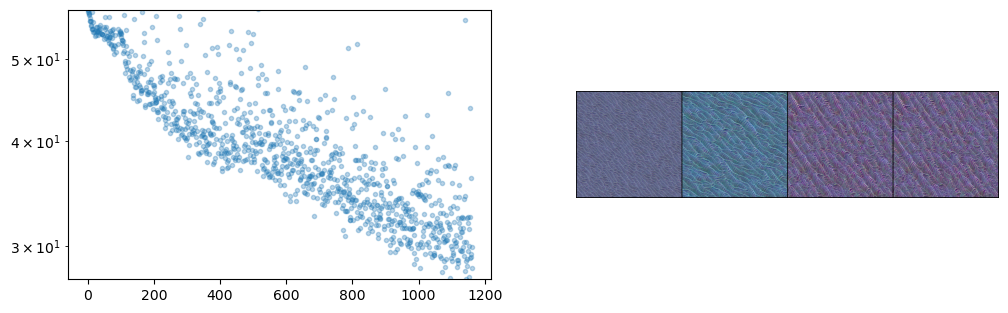

In [ ]:
learn.fit(1)

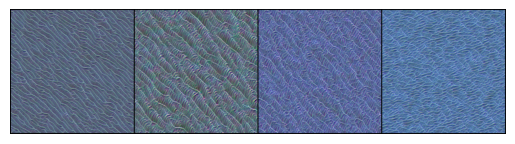

In [ ]:
# Check out the final batch:
rgb = model.to_rgb(learn.preds.detach())
rgb = torchvision.utils.make_grid(rgb)
show_image(rgb.clip(0, 1));

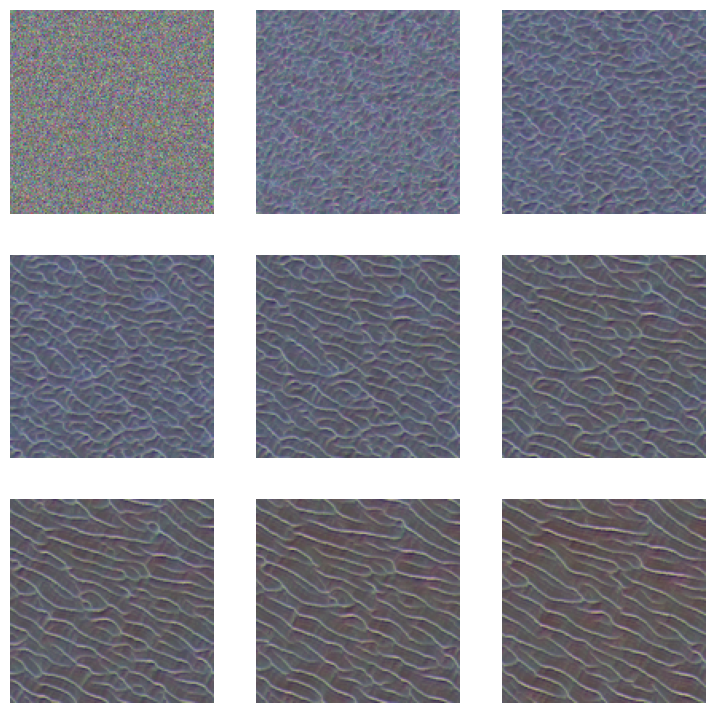

In [ ]:
# Apply a numbe of times to a random initial starting grid:
images = []
x = torch.randn(1, 4, 128, 128).to(def_device) * 0.1
for i in range(900):
    x = model(x)
    if i%100==0: images.append(model.to_rgb(x)[0].clip(0, 1))
show_images(images)

In [ ]:
sum(p.numel() for p in model.parameters()) # !!

168

In [ ]:
# TODO
# Another pass through re-factoring and adding prose
# Figure out a nice way to make little movies
# Link other resources